In [1]:
import numpy as np
import pandas as pd
import sys
import sqlite3

import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('plotting.mplstyle')

In [2]:
sys.path.insert(0, '/home/nsryan/Desktop/arfc/transition-scenarios/scripts')
mycolors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255"]

In [3]:
import cymetric as cym
from cymetric import graphs
import transition_metrics as tm
import dataframe_analysis as dta
import analysis as an
import collections

import nuclides
import fuel_transactions as tran

In [4]:
import requests
from collections import defaultdict

def read_reactor_data(url):
    """
    Reads NRC reactor data from a given URL and returns a dictionary with reactor names as keys and lists of power values as values.
    """
    reactor_data = {}

    reactor_data = defaultdict(list)

    response = requests.get(url)
    response.raise_for_status()
    lines = response.text.strip().split('\n')

    next(iter(lines))  # Skip the header line
    for line in lines[1:]:
        parts = line.strip().split('|')
        if len(parts) == 3:
            _, reactor, power = parts
            reactor_data[reactor].append(int(power))

    return reactor_data


url_2024 = "https://www.nrc.gov/reading-rm/doc-collections/event-status/reactor-status/2024/2024powerstatus.txt"

reactor_2024 = read_reactor_data(url_2024)

reactor_power_2024 = {}

len(reactor_2024['Clinton'])

for reactor, power_list in reactor_2024.items():
    power_list = np.array(power_list)/100
    reactor_power_2024[reactor] = list(map(float, power_list))

clinton_power = []
for i in range(len(reactor_power_2024['Clinton'])):
    clinton_power.append(reactor_power_2024['Clinton'][i])

clinton_power = np.array(clinton_power)

In [5]:
# current_outfile = f'power_percent_test_out_onlymod.sqlite'
current_outfile = f'power_percent_2024_test.sqlite'

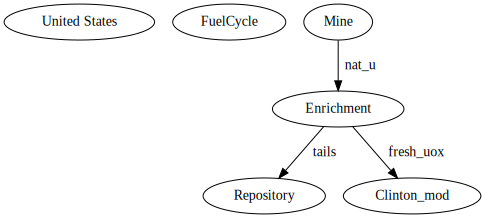

In [6]:
db = cym.dbopen(current_outfile)
evaler = cym.Evaluator(db, write=False)
graphs.flow_graph(evaler, label='com')

In [7]:
currents = ['Repository', 'Mine', 'Clinton_mod', 'Enrichment', 'United States', 'FuelCycle']

In [8]:
current_reactors = tm.get_lwr_totals(current_outfile, currents)
current_reactors = dta.add_year(current_reactors, y0=2024)

No agents were decommissioned during this simulation.


In [9]:
current_energy = tm.get_monthly_electricity(current_outfile, y0=2024)

In [10]:
current_energy

,Year,Energy
0,2024.000000,0.000
1,2024.083333,0.000
2,2024.166667,0.000
3,2024.250000,1.062
4,2024.333333,1.062
...,...,...
391,2056.583333,1.062
392,2056.666667,1.062
393,2056.750000,1.062
394,2056.833333,1.062


# this example is for the sake of others and will not need the same care of review as the original. We intend to reproduce the results and figures for the sake of completeness herein, but, in the event that is not possible, we are prepared to distribute results beyond this medium.

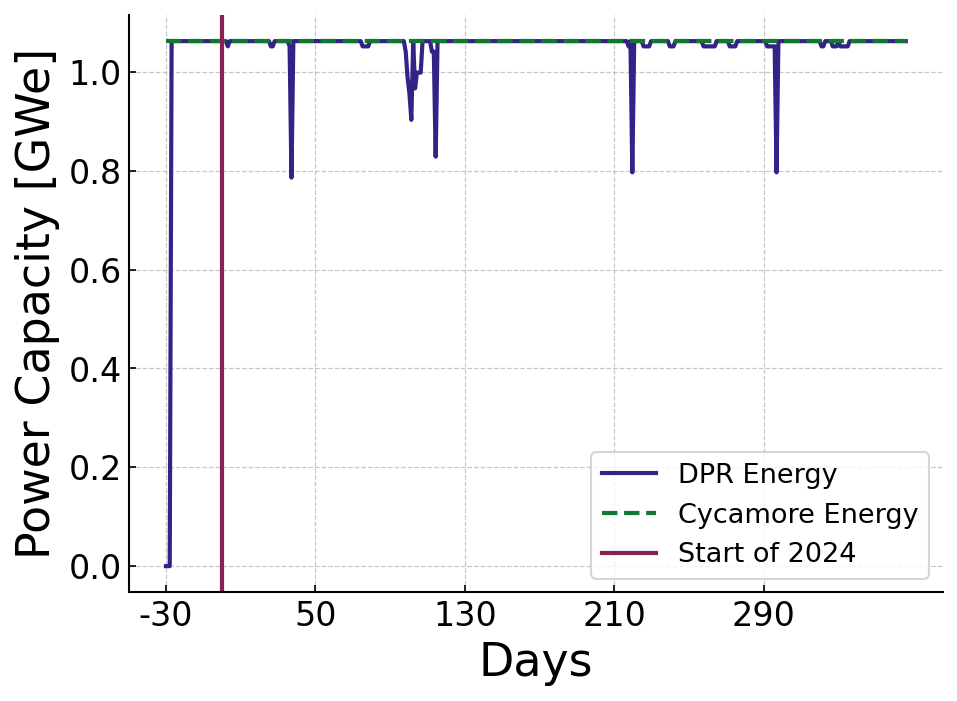

In [13]:
days = np.linspace(0,396,396)

plt.plot(days, current_energy['Energy'], label='DPR Energy')
plt.plot(days, [current_energy['Energy'][31]]*len(days),'--', label='Cycamore Energy')

plt.axvline(x = 30, color=mycolors[-1], label = 'Start of 2024')


plt.xlabel('Days')
plt.ylabel('Power Capacity [GWe]')

# New x-tick positions and labels
num = 80
new_xticks = np.arange(0, 396, num)
new_xlabels = np.arange(-30, 366, num)

# Set the new x-ticks
plt.xticks(new_xticks, new_xlabels)

# plt.xlim(30, 396)
# plt.ylim(0.7, 1.15)

plt.legend()

plt.savefig('dpr_cycamore_energy.pdf')

In [14]:
clinton_power_cap = 1.062
real_area_2024 = np.trapz(current_energy['Energy'][30:396]*clinton_power_cap, days[30:396])

In [15]:
real_area_2024

410.38731139443047

max diff 2.220446049250313e-16


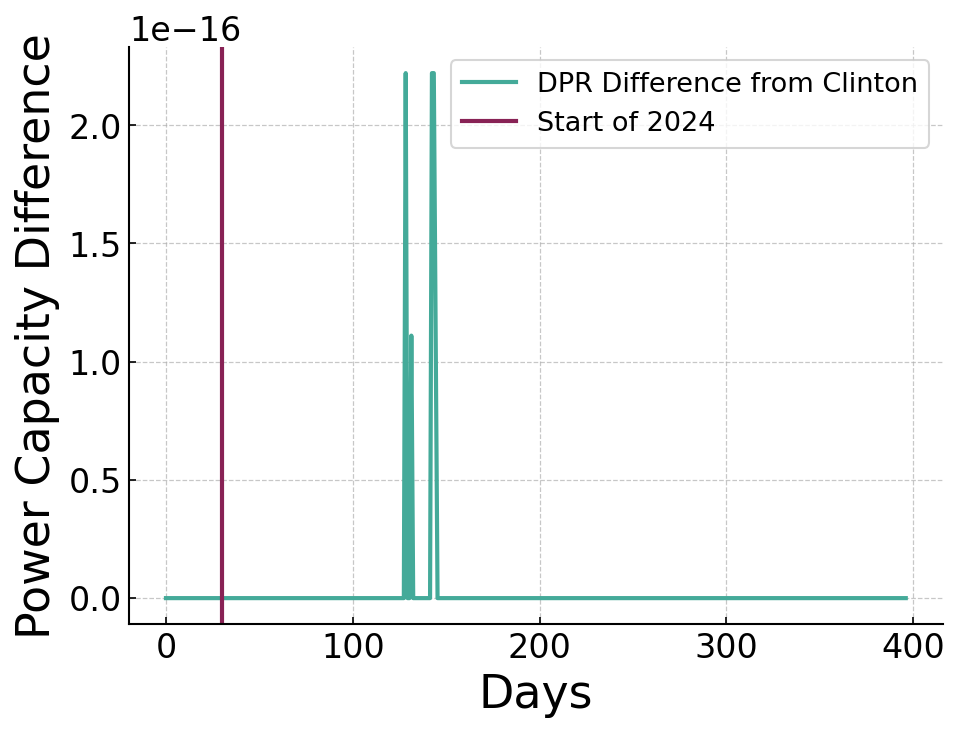

In [19]:
diff_clinton = clinton_power*clinton_power_cap - current_energy['Energy'][30:].to_numpy()

# create indexes 0:30 to 0 for diff_clinton
diff_clinton = np.concatenate((np.zeros(30), diff_clinton))

print('max diff', max(diff_clinton))

plt.plot(days, diff_clinton, color=mycolors[-6], label = 'DPR Difference from Clinton')

plt.axvline(x = 30, color=mycolors[-1], label = 'Start of 2024')


plt.ylabel('Power Capacity Difference')
plt.xlabel('Days')

plt.legend()

plt.savefig('dpr_diff.pdf')

# Fresh Fuel

In [12]:
current_transactions = tm.add_receiver_prototype(current_outfile)
current_uox = dta.commodity_mass_traded(current_transactions, 'fresh_uox')

In [13]:
current_uox

,Time,Quantity,Year
0,0,0.000000,1958.00
1,1,123941.908714,1958.08
2,2,123941.908714,1958.17
3,3,18804.979253,1958.25
4,4,0.000000,1958.33
...,...,...,...
1747,1747,0.000000,2103.58
1748,1748,0.000000,2103.67
1749,1749,0.000000,2103.75
1750,1750,0.000000,2103.83


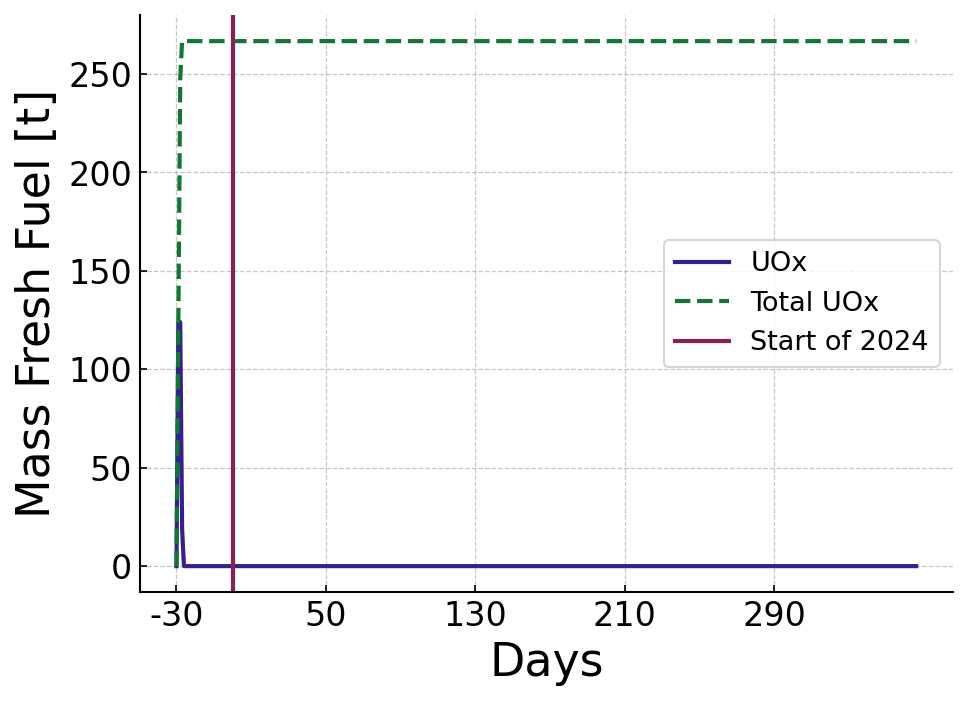

In [37]:
plt.plot(days, current_uox['Quantity'][:len(days)]/1000, label='UOx')
plt.plot(days, current_uox['Quantity'][:len(days)].cumsum()/1000, label='Total UOx', linestyle='--')

plt.axvline(x = 30, color=mycolors[-1], label = 'Start of 2024')

plt.ylabel('Mass Fresh Fuel [t]')
plt.xlabel('Days')

# New x-tick positions and labels
num = 80
new_xticks = np.arange(0, 396, num)
new_xlabels = np.arange(-30, 366, num)

# Set the new x-ticks
plt.xticks(new_xticks, new_xlabels)

plt.legend()

In [42]:
used_uox = dta.commodity_mass_traded(current_transactions, 'used_uox')

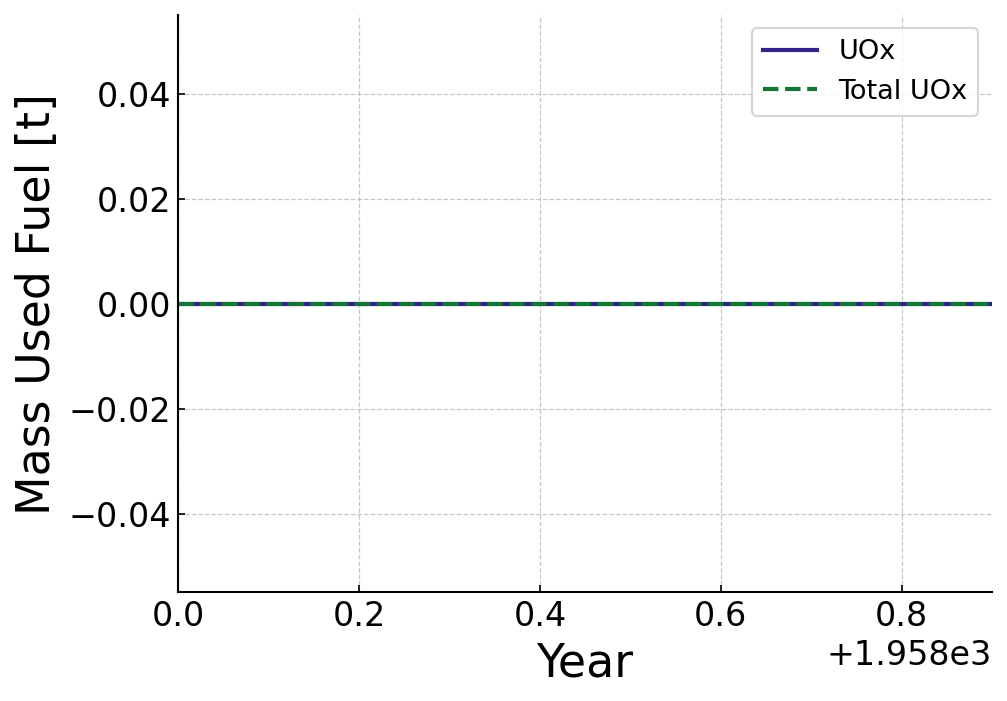

In [43]:
plt.plot(used_uox['Year'], used_uox['Quantity']/1000, label='UOx')
plt.plot(used_uox['Year'], used_uox['Quantity'].cumsum()/1000, label='Total UOx', linestyle='--')


plt.ylabel('Mass Used Fuel [t]')
plt.xlabel('Year')
plt.xlim(1958, 1958.9)

plt.legend()

In [44]:
#Defining assays for LEU product, tails, and feed material
leu_p = 0.045
mmrh_p = 0.1975
mmrl_p = 0.0995
xeh_p = 0.155
xel_p = 0.0995
x_f = 0.00711
x_t = 0.002

In [45]:
current_tails_lwr = dta.calculate_tails(current_uox['Quantity'], leu_p, x_t, x_f)
current_feed_lwr = dta.calculate_feed(current_uox['Quantity'], current_tails_lwr)
current_swu_lwr = dta.calculate_SWU(current_uox['Quantity'], leu_p,
                               current_tails_lwr, x_t,
                               current_feed_lwr, x_f)
current_swu_lwr = current_swu_lwr.to_frame().reset_index()
current_swu_lwr = current_swu_lwr.rename(columns={'Quantity':'SWU', 'index':'Time'})
current_swu_lwr = dta.add_year(current_swu_lwr)

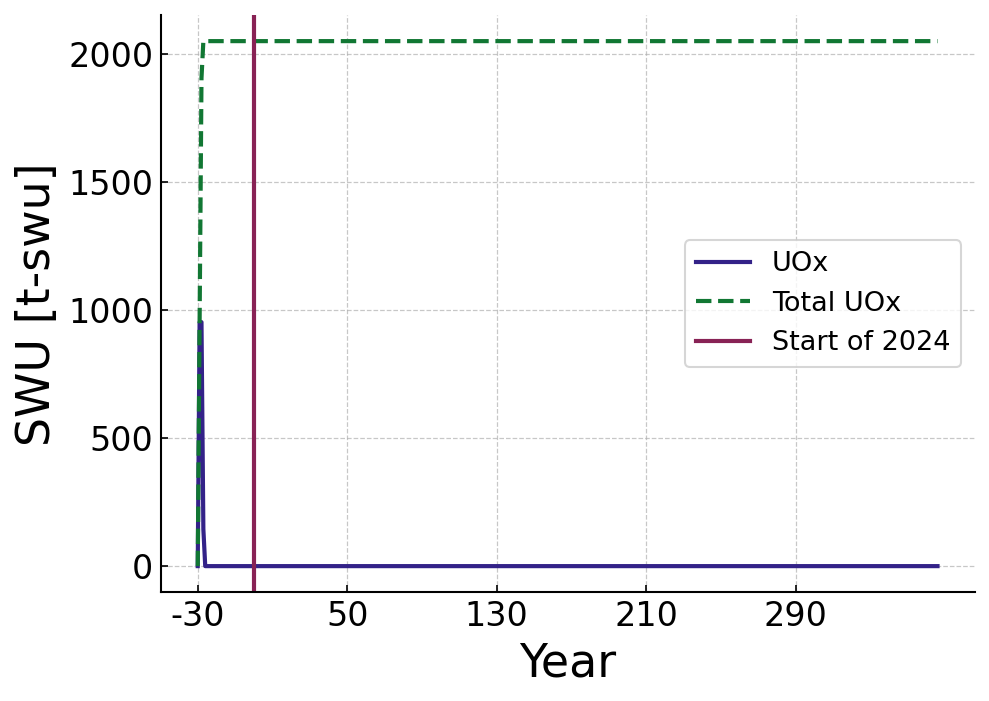

In [47]:
plt.plot(days, current_swu_lwr['SWU'][:len(days)]/1000, label='UOx')
plt.plot(days, current_swu_lwr['SWU'][:len(days)].cumsum()/1000, label='Total UOx', linestyle='--')

plt.axvline(x = 30, color=mycolors[-1], label = 'Start of 2024')


plt.ylabel('SWU [t-swu]')
plt.xlabel('Year')


# New x-tick positions and labels
num = 80
new_xticks = np.arange(0, 396, num)
new_xlabels = np.arange(-30, 366, num)

# Set the new x-ticks
plt.xticks(new_xticks, new_xlabels)

plt.legend()